In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_rand

import sklearn

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

import pickle
import itertools

## Load data

In [28]:
full_data_vector = pd.read_csv('../../learning_vectors/v05/version5-complete.csv', sep=',')

selected_features = ["H_age","A_age","H_TMV","A_TMV","H_MeanShotsOnTarget03","A_MeanShotsOnTarget03","H_MeanShotsOnTarget05","A_MeanShotsOnTarget05","H_MeanFullTimeGoals03","A_MeanFullTimeGoals03","H_MeanFullTimeGoals05","A_MeanFullTimeGoals05","H_WeightedMeanShots05","A_WeightedMeanShots05","H_WeightedMeanShotsOnTarget05","A_WeightedMeanShotsOnTarget05","H_WeightedMeanFullTimeGoals05",'A_WeightedMeanFullTimeGoals05']
X = full_data_vector[selected_features]
Y = full_data_vector['Result']
X = X.values
Y = Y.values


## Randomized search for the best KNN Classifier and show best score

In [29]:
knn_model = KNeighborsClassifier()
knn_param_grid = {'weights': ['uniform', 'distance'],
                  'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'p' : sp_randint(2, 20),
                  'n_neighbors': sp_randint(1, 200),
                  'metric' : ["euclidean", "manhattan", "chebyshev"]}
knn_rsearch = RandomizedSearchCV(estimator=knn_model, param_distributions=knn_param_grid, n_iter=10)
knn_rsearch.fit(X, Y)
print str(knn_rsearch.best_score_) + "%\t-\t" + "best KNN found in 100 iterations" + "\n" + str(knn_rsearch.best_estimator_)

0.534703947368%	-	best KNN found in 100 iterations
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=139, p=9,
           weights='uniform')


## Train a single CART classifier and check best performance

In [42]:
cart_model = DecisionTreeClassifier()
cart_param_grid = {'criterion': ['gini', 'entropy'],
                  'splitter' : ['best', 'random'],
                  'max_depth' : sp_randint(2, 200),
                  'min_samples_split': sp_rand(0, 1),
                  'min_samples_leaf' : sp_randint(1, 300)}
cart_rsearch = RandomizedSearchCV(estimator=cart_model, param_distributions=cart_param_grid, n_iter=50)
cart_rsearch.fit(X, Y)
print str(cart_rsearch.best_score_) + "%\t-\t" + "best KNN found in 10 iterations" + "\n" + str(cart_rsearch.best_estimator_)

0.531907894737%	-	best KNN found in 10 iterations
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=44, min_samples_split=0.53717442663656401,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')


## Randomly split data into train and test (the "randomly part is important")

In [87]:
msk = np.random.rand(len(X)) < 0.8

X_train, X_test = X[msk], X[~msk]
y_train, y_test = Y[msk], Y[~msk]

## Train an ADA Boost Classifier with a default CART Classifier

In [88]:
boost_model = DecisionTreeClassifier(max_depth=2)

bdt_real = AdaBoostClassifier(
    boost_model,
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    boost_model,
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.5, n_estimators=600, random_state=None)

## Show errors for real and discrete boosting in a staged_predict

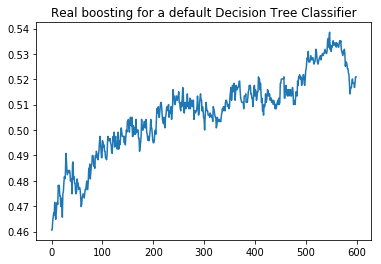

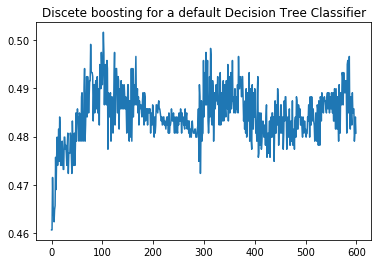

In [90]:
real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

plt.title("Real boosting for a default Decision Tree Classifier")
plt.plot(real_test_errors)
plt.show()

plt.title("Discete boosting for a default Decision Tree Classifier")
plt.plot(discrete_test_errors)
plt.show()

## Show a normal predict() accuracy on the test train set

In [92]:
predicted = bdt_real.predict(X_train)

score = 0

for x in range(len(predicted)):
    if predicted[x] == y_train[x]:
        score = score + 1

score = float(score) / float(len(predicted))
print score

0.69177241097


## Train ADA Boost classifier on the best CART model we found in RandomizedSearch - we use a new set of data, again randomly selected)

In [100]:
boost_model = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=44, min_samples_split=0.53717442663656401,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

msk = np.random.rand(len(X)) < 0.8

X_train, X_test = X[msk], X[~msk]
y_train, y_test = Y[msk], Y[~msk]

bdt_real = AdaBoostClassifier(
    boost_model,
    n_estimators=600,
    learning_rate=1)

bdt_discrete = AdaBoostClassifier(
    boost_model,
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=44, min_samples_split=0.537174426637,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=1.5, n_estimators=600, random_state=None)

## Show errors for real and discrete boosting in a staged_predict

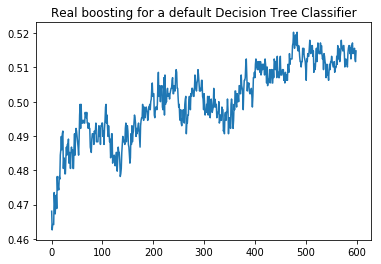

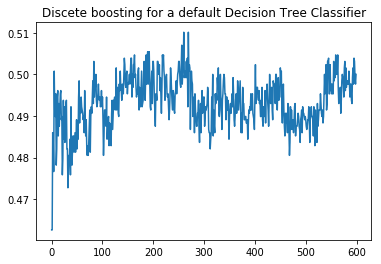

In [101]:
real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(
        1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(
        1. - accuracy_score(discrete_train_predict, y_test))

plt.title("Real boosting for a default Decision Tree Classifier")
plt.plot(real_test_errors)
plt.show()

plt.title("Discete boosting for a default Decision Tree Classifier")
plt.plot(discrete_test_errors)
plt.show()

## Show actual accuracy

In [102]:
predicted = bdt_real.predict(X_train)

score = 0

for x in range(len(predicted)):
    if predicted[x] == y_train[x]:
        score = score + 1

score = float(score) / float(len(predicted))
print score

0.63469557965
